# Example 04. Develop a voxel-based model of $P_{gap}$

This example builds a voxel-based model of directional gap probability, $P_{gap}$($\theta$), using multiple scan positions. The model is still currently in development and may produce unintended results.

## Load all the required modules

In [1]:
import os
import json
import glob
import numpy as np
import rasterio as rio

from scipy import constants, ndimage

from pylidar_tls_canopy import voxelization, riegl_io, visualize

## Settings

In [3]:
voxelsize = 1.0 # Voxel grid resolution (m)
buffer = 5 # Extend voxel bounds by this buffer (m)
hmax = 50 # Maximum tree height (m)
min_n = 3 # Minimum number of Pgap observations required to estimate PAI

## Identify all of the input files

We need both the RDBX and RXP files for the VZ400i and later scanner models. The RDBX have the point cloud corrected with RIEGL MTA processing, and the RXP files have all the pulse information for shots with no returns, allowing us to separate the absence of a return from the absence of a measurement.

If you are using a RIEGL VZ400 scanner or used a pulse rate <= 300khz, then you only need the RXP files.

You may need to modify the following cell, depending on how your data is organized.

In [4]:
# RiScanPro project directory
os.chdir('/gpfs/data1/vclgp/data/tls_point_clouds/riegl_registered/neon_serc_220305_024625.RiSCAN')

# Get the list of input files
rxp_fn = []
rdbx_fn = []
transform_fn = []
for d in os.listdir('SCANS'):
    if os.path.isdir(f'SCANS/{d}') and d.startswith('ScanPos'):
        
        # RXP
        fpath = f'SCANS/{d}/SINGLESCANS/??????_??????.rxp'
        flist = glob.glob(fpath)
        fn = max(flist, key=os.path.getctime)
        rxp_fn.append(fn)
        
        # RDBX
        prefix,suffix = os.path.splitext(fn)
        scan = os.path.basename(prefix)
        fn = f'project.rdb/SCANS/{d}/SINGLESCANS/{scan}/{scan}.rdbx'
        rdbx_fn.append(fn)
        
        # Transform
        fn = f'SCANS/matrix/{d}.DAT'
        transform_fn.append(fn)

# DTM (at present these need to be generated independently, in the same local coordinate system as the TLS data)
local_dtm = '/gpfs/data1/vclgp/data/tls_point_clouds/dtms/neon_serc_220305_024625/local.tif'

# Output directory
outdir = '/gpfs/data1/vclgp/armstonj/tls_temp'

## Get the bounds of the voxelization

In [5]:
# xmin,ymin,zmin,xmax,ymax,zmax
bounds = np.array([np.Inf,np.Inf,np.Inf,-np.Inf,-np.Inf,-np.Inf])
for fn in transform_fn:
    transform_matrix = riegl_io.read_transform_file(fn)
    x_tmp,y_tmp,z_tmp,_ = transform_matrix[3,:]
    bounds[0] = x_tmp if x_tmp < bounds[0] else bounds[0]
    bounds[1] = y_tmp if y_tmp < bounds[1] else bounds[1]
    bounds[2] = z_tmp if z_tmp < bounds[2] else bounds[2]
    bounds[3] = x_tmp if x_tmp > bounds[3] else bounds[3]
    bounds[4] = y_tmp if y_tmp > bounds[4] else bounds[4]
    bounds[5] = z_tmp if z_tmp > bounds[5] else bounds[5]

bounds[0:3] = (bounds[0:3] - buffer) // buffer * buffer
bounds[3:6] = (bounds[3:6] + 1.5 * buffer) // buffer * buffer
bounds[2] -= buffer
bounds[5] += hmax
bounds

array([-10., -30., -20.,  20.,   5.,  50.])

## Process a single scan on a defined voxel grid

In [6]:
vgrid = voxelization.VoxelGrid(dtm_filename=local_dtm)

In [7]:
# set rdbx_file to None if only the RXP file is needed
vgrid.add_riegl_scan_position(rxp_fn[-1], transform_fn[-1], rdbx_file=None)

In [8]:
vgrid.voxelize_scan(bounds, voxelsize, save_counts=True)

In [9]:
prefix,suffix = os.path.splitext(rxp_fn[0])
scan = os.path.basename(prefix)
prefix = f'{outdir}/{scan}'
vgrid.write_grids(prefix)

## Visualize the single scan voxel outputs

In [10]:
viz = visualize.VizVoxelGrid(figsize=[15,4], ncols=3, nrows=1)

names = ['hits','miss','occl']
titles = ['Hit','Miss','Occluded']
vmin_vals=[0,-100,0]
vmax_vals=[1000,10000,10000]

viz.create_viz(vgrid.filenames, layer=1, names=names, voxelsize=voxelsize,
    vmin_vals=vmin_vals, vmax_vals=vmax_vals, titles=titles, 
    interval=50, frames=57, bounds=bounds)

In [11]:
viz = visualize.VizVoxelGrid(figsize=[18,4], ncols=4, nrows=1)

names = ['pgap','vcls','vwts','zeni']
titles = [r'$P_{gap}$','Class','Total Path Length','Zenith']
vmin_vals = [0,1,0,0]
vmax_vals = [1,5,10000,np.pi]

viz.create_viz(vgrid.filenames, layer=1, names=names, voxelsize=voxelsize,
    vmin_vals=vmin_vals, vmax_vals=vmax_vals, titles=titles, 
    interval=50, frames=57, bounds=bounds)

In [12]:
names = ['pgap','vcls','vwts','zeni']
z = 20
elev = bounds[2] + z * voxelsize

src = [rio.open(vgrid.filenames[k]) for k in sorted(vgrid.filenames) if k in names]
data_s = [s.read(z+1) for s in src]

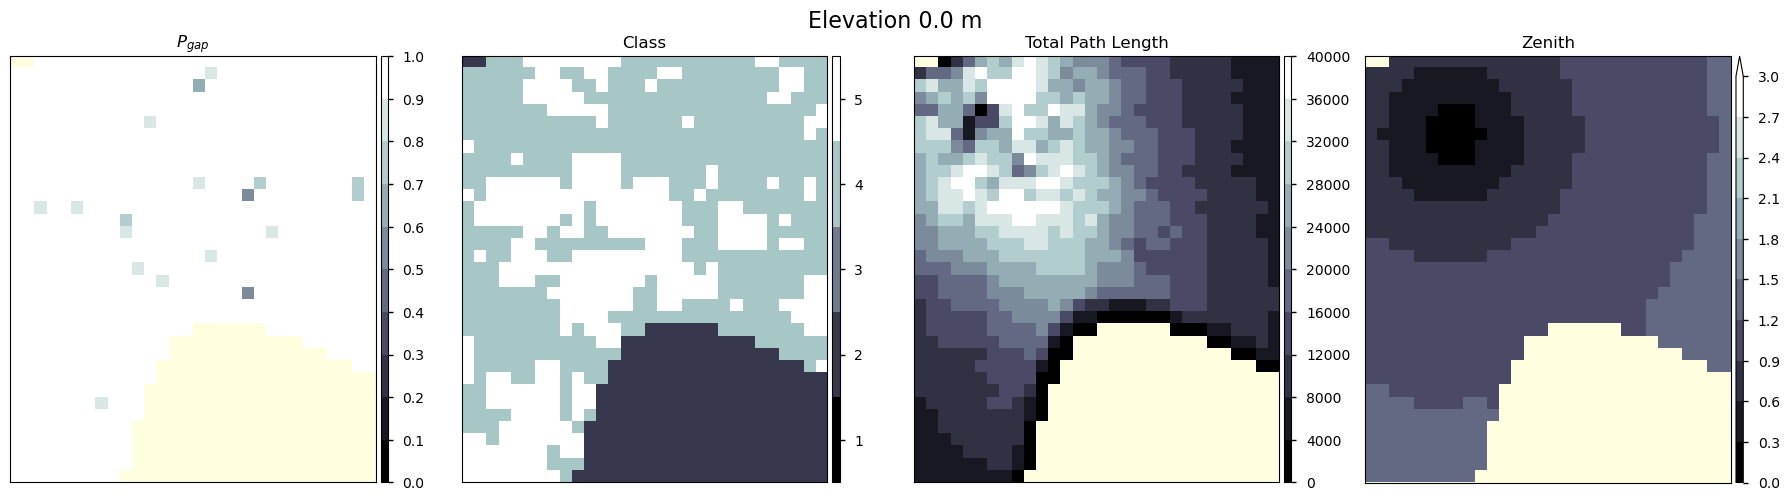

In [13]:
clim = [[0,1],[0.5,5.5],[0,40000],[0,3]]
nbins = [10,5,10,10]
title = [r'$P_{gap}$','Class','Total Path Length','Zenith']
extend = ['neither','neither','neither','max']
cmap = ['bone','bone','bone','bone']

visualize.plot_voxel_grid(data_s, title=title, clim=clim, figsize=(18,5), nbins=nbins,
                cmap=cmap, extend=extend, nodata=-9999, extent=None,
                xlabel=None, ylabel=None, facecolor='lightyellow', 
                suptitle=f'Elevation {elev:.1f} m')

## Process each scan on the voxel grid

In [14]:
config = {}
config['bounds'] = bounds.tolist()
config['resolution'] = voxelsize
config['nx'] = int( (bounds[3] - bounds[0]) // voxelsize)
config['ny'] = int( (bounds[4] - bounds[1]) // voxelsize)
config['nz'] = int( (bounds[5] - bounds[2]) // voxelsize)
config['nodata'] = -9999
config['dtm'] = local_dtm
config['positions'] = {}

In [15]:
%%time

npos = len(rxp_fn)
for i in range(npos):
    fn = os.path.basename(rxp_fn[i]) 
    name = os.path.splitext(fn)[0]
    vgrid_i = voxelization.VoxelGrid(dtm_filename=local_dtm)
    vgrid_i.add_riegl_scan_position(rxp_fn[i], transform_fn[i], rdbx_file=None)
    vgrid_i.voxelize_scan(bounds, voxelsize, save_counts=True)
    prefix = f'{outdir}/{name}'
    vgrid_i.write_grids(prefix)
    config['positions'][name] = vgrid_i.filenames

CPU times: user 11min 49s, sys: 4min 29s, total: 16min 19s
Wall time: 16min 18s


In [16]:
config_fn = f'{outdir}/neon_serc_220305_024625_config.json'

In [17]:
with open(config_fn, 'w') as f:
    tmp = json.dumps(config, indent=4)
    f.write(tmp)

## Derive PAI and the vertical canopy cover profile

In [18]:
vmodel = voxelization.VoxelModel(config_fn)
paiv,paih,nscans = vmodel.run_linear_model(min_n=min_n, weights=False)
cover_z = vmodel.get_cover_profile(paiv)

## Visualize the multiple scan voxel outputs

In [19]:
elev = vmodel.bounds[2] + vmodel.nz * vmodel.resolution

paiv = np.ma.masked_equal(paiv, vmodel.nodata)
paih = np.ma.masked_equal(paih, vmodel.nodata)
nscans = np.ma.masked_equal(nscans, vmodel.nodata)

data_m = [paiv.mean(axis=0),
          paih.mean(axis=0),
          nscans[z],
          cover_z.max(axis=0)]

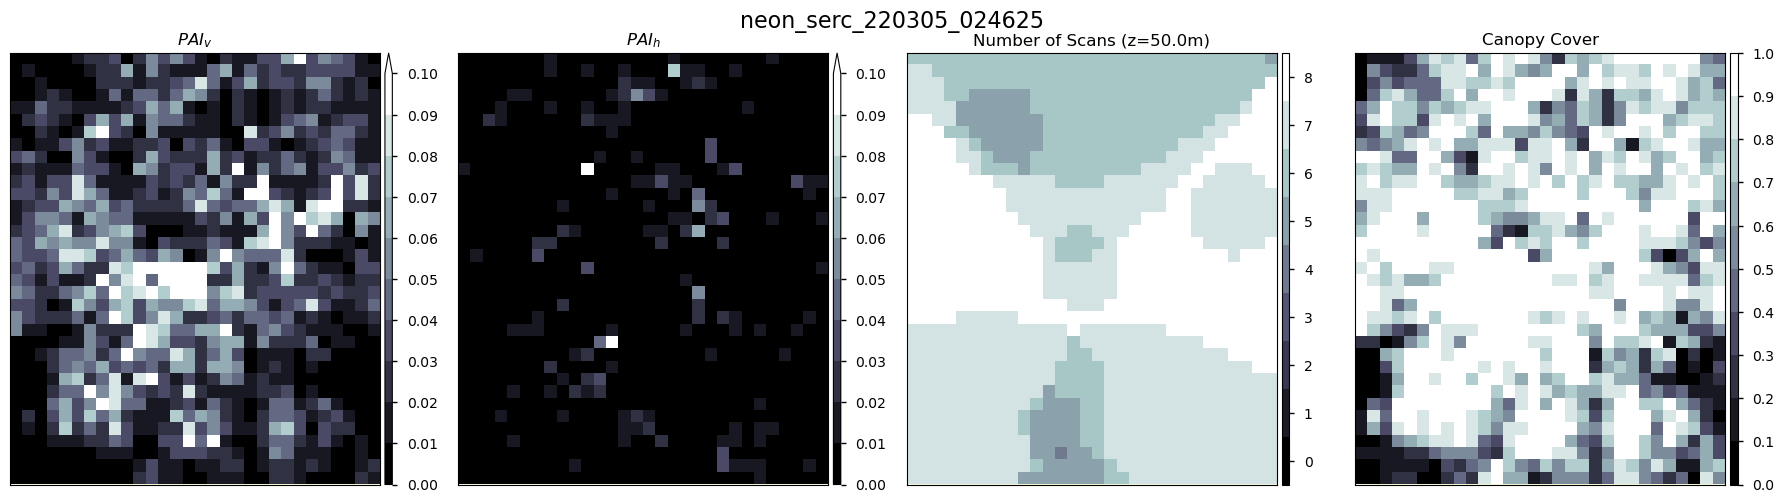

In [20]:
clim = [[0,0.1],[0,0.1],[-0.5,8.5],[0,1]]
nbins = [10,10,9,10]
title = [r'$PAI_{v}$',
         r'$PAI_{h}$',
         f'Number of Scans (z={elev:.1f}m)',
         'Canopy Cover']
extend = ['max','max','neither','neither']
cmap = ['bone','bone','bone','bone']

visualize.plot_voxel_grid(data_m, title=title, clim=clim, figsize=(18,5), nbins=nbins,
                cmap=cmap, extend=extend, nodata=vmodel.nodata, extent=None,
                xlabel=None, ylabel=None, facecolor='lightyellow', 
                suptitle='neon_serc_220305_024625')

## Run a very basic simulation of a GEDI waveform

A very simple simulation. See Hancock et al. (2019) and DART for details.

In [21]:
# GEDI wavefront
x,y = np.meshgrid(np.linspace(bounds[0],bounds[3],cover_z.shape[2]), 
                  np.linspace(bounds[1],bounds[4],cover_z.shape[1]))
fsigma,mu = 5.5,0.0
x0,y0 = 0,0
d = np.sqrt((x-x0)**2 + (y-y0)**2)
g = np.exp(-( (d - mu)**2 / ( 2 * fsigma**2 ) ) ) 

# GEDI pulse
sigma = 15.6 / np.sqrt(8 * np.log(2))
psigma = sigma * (constants.c / 1e9 / 2) / voxelsize

# GEDI footprint vertical cover profile
gedi_cover = cover_z * g
gedi_cover_z = gedi_cover.sum(axis=(1,2)) / g.sum()
gedi_pavd_z = -np.gradient(-2 * np.log(1-gedi_cover_z), voxelsize)
gedi_height_z = bounds[2] + np.arange(gedi_cover_z.shape[0]) * voxelsize

# GEDI received canopy waveform
nbelow = 10
gedi_wf_z = np.pad(gedi_cover_z, (nbelow,0), constant_values=gedi_cover_z[0])
gedi_wf_dz = -np.gradient(gedi_wf_z, voxelsize)
gedi_canopy_waveform = ndimage.gaussian_filter1d(gedi_wf_dz, psigma)
gedi_elev_z = bounds[2] - (nbelow * voxelsize) + np.arange(gedi_wf_dz.shape[0]) * voxelsize

# GEDI received ground waveform
gedi_pgap = (1 - cover_z[0]) * g
gedi_ground = np.zeros(cover_z.shape, dtype=float)
idx = np.argmin(vmodel.dtm_voxelgrid, axis=0, keepdims=True)
np.put_along_axis(gedi_ground, idx, gedi_pgap, 0)
gedi_ground = gedi_ground.sum(axis=(1,2)) / g.sum()
gedi_ground_tmp = np.pad(gedi_ground, (nbelow,0), constant_values=0)
gedi_ground_waveform = ndimage.gaussian_filter1d(gedi_ground_tmp, psigma)

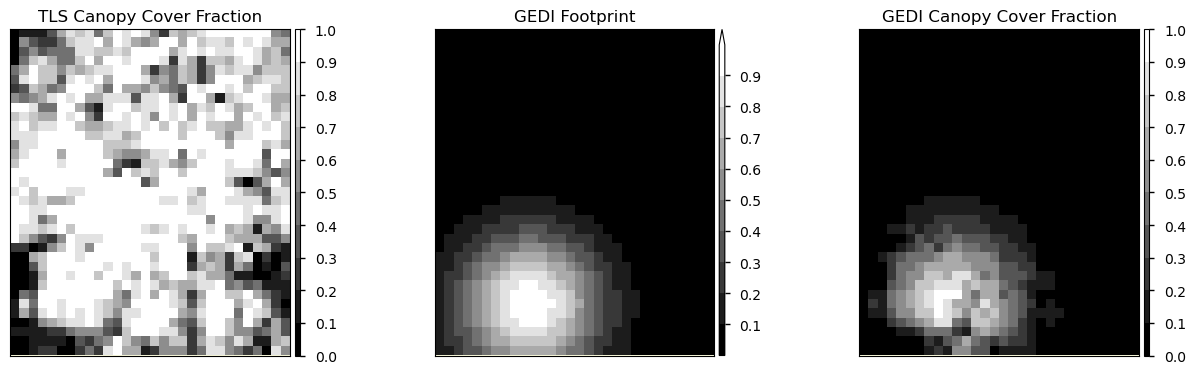

In [22]:
tmp = [cover_z.max(axis=0), g, gedi_cover.max(axis=0)]

title = ['TLS Canopy Cover Fraction','GEDI Footprint','GEDI Canopy Cover Fraction']
cmap = ['gist_gray','gist_gray','gist_gray']
clim = [[0,1],[None,None],[0,1]]
nbins = [10,10,10]
extend = ['neither','max','neither']

visualize.plot_voxel_grid(tmp, title=title, clim=clim, figsize=(13,4), nbins=nbins,
                cmap=cmap, extend=extend, nodata=-9999, extent=None,
                xlabel=None, ylabel=None, facecolor='lightyellow', suptitle=None)

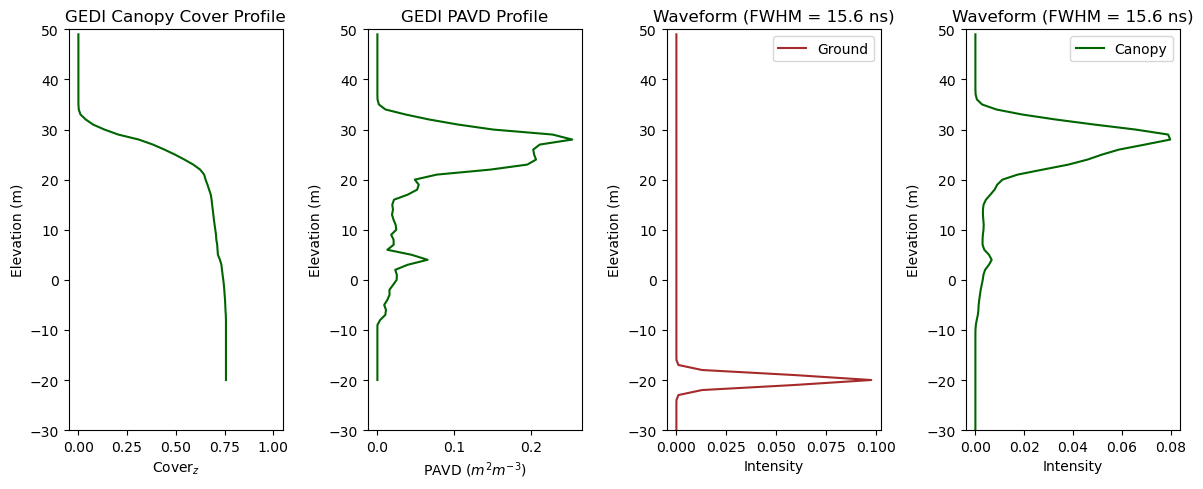

In [23]:
# Plot the profiles
config = [{'title':'GEDI Canopy Cover Profile','color':'DarkGreen','xlabel':r'Cover$_{z}$','ylabel':'Elevation (m)',
           'xlim':[-0.05,1.05],'ylim':[-30,50],'label':None,'legend':False,'linestyle':None},
          {'title':'GEDI PAVD Profile','color':'DarkGreen','xlabel':r'PAVD ($m^{2} m^{-3}$)','ylabel':'Elevation (m)',
           'xlim':None,'ylim':[-30,50],'label':None,'legend':False,'linestyle':None},
          {'title':'Waveform (FWHM = 15.6 ns)','color':'Brown','xlabel':'Intensity','ylabel':'Elevation (m)',
           'xlim':None,'ylim':[-30,50],'label':'Ground','legend':True,'linestyle':None},
          {'title':'Waveform (FWHM = 15.6 ns)','color':'DarkGreen','xlabel':'Intensity','ylabel':'Elevation (m)',
           'xlim':None,'ylim':[-30,50],'label':'Canopy','legend':True,'linestyle':None}]

x = [gedi_cover_z, gedi_pavd_z, gedi_ground_waveform, gedi_canopy_waveform]
y = [gedi_height_z, gedi_height_z, gedi_elev_z, gedi_elev_z]
visualize.plot_voxel_profiles(x, y, ncols=4, nrows=1, config=config)